# 基于迁移学习方法的人脸识别

以下为该项目的一般流程和实现代码以及运行结果

## 任务介绍

人脸识别是一个计算机视觉任务，任务是要通过一张带有人脸的图像，对图像中的人脸进行识别并判断是谁。关于人脸识别的任务，我们一定会用到2015年Google开发的FaceNet，这个模型由于其性能非常好而被广泛使用，并且该训练好的模型已经被开源。

因此，本项目的任务将要学习人脸识别任务，在此项目中，我们将先亲手搭建一个卷积神经网络，然后，我们将用高级的网络结构，比如ResNet50再次进行人脸识别任务，最后我们将用到预训练好的FaceNet模型。在这个过程中，我们还会用到数据增强和人脸抽取技术来提升人脸识别的精确度。

在这个人脸识别项目中，我们将使用一个开源数据集[Five Celebrity Faces Dataset](kaggle.com/dansbecker/5-celebrity-faces-dataset)，这也是一个在Kaggle比赛中的一个数据集。我们也已经下载好了并放在`./5-celebrity-faces-dataset`中，数据集中包含五位名人的照片，Ben Affleck, Elton John, Jerry Seinfeld, Madonna, Mindy Kaling。文件下分`train`和`val`。

## 数据准备
我们首先要简单的观察数据，然后通过数据增强和人脸抽取技术对数据图像数据进行抽取。

### 显示一张图像

所有 train下面的图像文件名都存入 images 列表中，并将该图像的人名按顺序存于 images_name 中

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import PIL
data_root = "./5-celebrity-faces-dataset/train/"

In [3]:
# 把所有 train下面的图像文件名都存入 images 列表中，并将该图像的人名按顺序存于 images_name 中
images = []
images_name = []
for imgfolder in os.listdir(data_root):
    for filename in os.listdir(data_root + imgfolder):
        filename = data_root + imgfolder + '/' + filename
        images.append(filename)
        images_name.append(imgfolder)

从`images`中随机读取一张图像，使用 `cv2.imread`读取图像，然后使用`pyplot.imshow`显示图像。注意：你需要同时显示该图像对应的人名，以及打印该图像的`shape`。

随机选取一张照片：


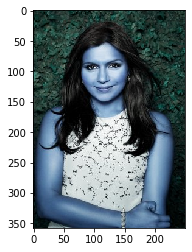

mindy_kaling
(358, 250, 3)


('./5-celebrity-faces-dataset/train/mindy_kaling/httpsimagesnasslimagesamazoncomimagesIAQdwKvFILUXjpg.jpg',
 'mindy_kaling')

In [4]:
# 从images 中随机读取一张图像，并获得该图像中的人名
def random_sample(images=images, images_name=images_name):
    print("随机选取一张照片：")
    # 从 images 和 images_name 随机读取一个图像文件路径以及该图像的人名
    num = random.randint(0,len(images))
    im_file, im_name = images[num],images_name[num]
    # 使用 cv2.imread 读取图像文件
    img = cv2.imread(im_file)
    # 使用 plt.imshow 和 plt.show() 显示图像
    plt.imshow(img)
    plt.show()
    # 打印该图像的人名
    print(im_name)
    # 打印该图像的大小 shape
    print(img.shape)
    return im_file, im_name

random_sample(images, images_name)

你可以多次运行上面的代码来多观察一些人物图像，以此来对数据有一个大致的认知

用`cv2.imread`读取所有数据并存入`train_x`中，然后用 0,1,2,3,4 来标记 Ben Affleck, Elton John, Jerry Seinfeld, Madonna, Mindy Kaling，并将所有`images_name`数据存入`train_y`中。

### 数据增强

首先，我们需要打印训练集的数量。

In [5]:
print(len(images))

93


我们可以看到，训练集的图像数量比较少，这对模型建模并学习图像数据到人名标签的映射关系增加了难度。这里我们将采用数据增强技术扩充原有训练集，关于数据增强的基础知识，可参考这篇文章——[Data Augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)。


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# 构造图像数据增强器

data_gen = ImageDataGenerator(
    rescale = 0.5, # 随机缩放图像RGB值的倍数
    rotation_range =40 , # 随机旋转图像的范围
    zoom_range =0.2 ,  # 随机缩放图像大小范围
    width_shift_range =0.2 ,  # 随机水平方向平移图像(fraction of total width)
    height_shift_range=0.2 ,  # 随机纵向平移图像(fraction of total height)
)



Using TensorFlow backend.


使用 `flow_from_directory` 遍历数据集 `./5-celebrity-faces-dataset/data`，来观察数据增强的表现。先得到一个图像迭代器，该迭代器每次都从路径里读取一个图像，并按照数据增强器的规则进行编辑图像

In [7]:
# 直接运行，得到一个图像迭代器，该迭代器每次都从路径里读取一个图像，并按照数据增强器的规则进行编辑图像
dataflow_generator = data_gen.flow_from_directory(
    "./5-celebrity-faces-dataset/data",
    target_size=(160, 160),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical')

Found 5 images belonging to 5 classes.


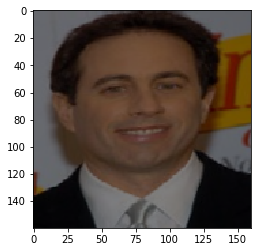

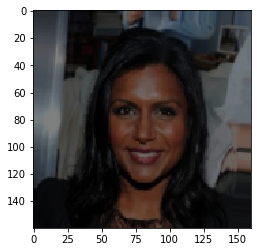

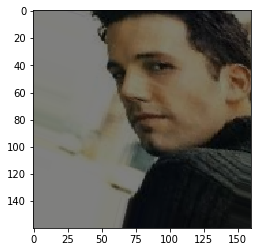

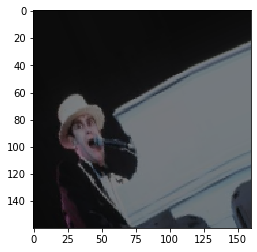

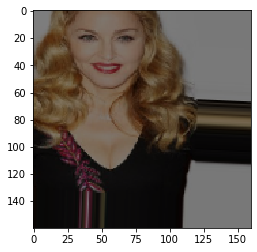

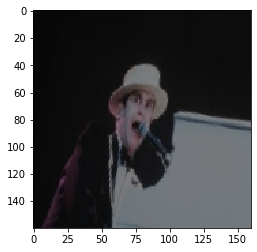

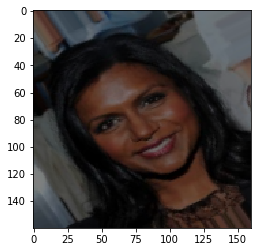

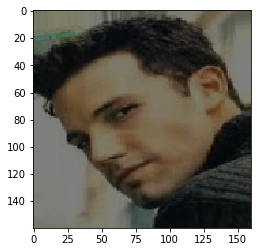

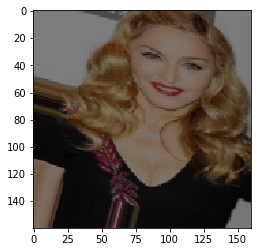

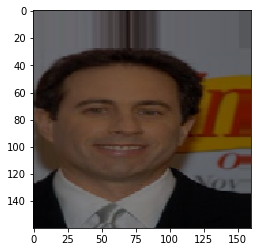

In [8]:
# 从 迭代器中 读取10张图片，并显示图像

sample_count = 10
for image_data in dataflow_generator:
    # 使用 plt.imshow 和 plt.show() 显示图像
    plt.imshow(image_data[0][0].astype(int))
    plt.show()
    
    sample_count -= 1
    if sample_count <= 0:
        break  

### 人脸抽取

在做人脸识别任务中，一项常用的图像数据处理的技术是人脸检测（Face Detection）。人脸检测是将输入的图片中的人脸部分自动检测出来，具体来说就是要通过预测一个矩形边界框（Bounding Box）从整个图像中定位人脸部分，这里的矩形边界框由矩形左下角坐标以及矩形高和宽来定义。人脸检测是一个比较成熟的任务，接下来在我们这个项目中，我们将使用 Multi-Task Cascaded Convolutional Neural Network，MTCNN，你也可以参考论文：[Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks](https://arxiv.org/abs/1604.02878)，来学习人脸检测任务。

In [9]:
# 运行下面代码，安装 mtcnn
!pip install mtcnn

随机选取一张照片：


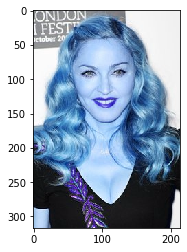

madonna
(317, 214, 3)




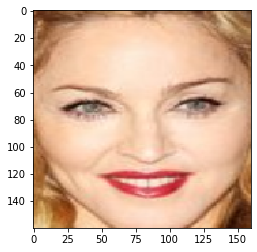

(160, 160, 3)


In [10]:
# 定义人脸抽取的函数
from PIL import Image
from mtcnn.mtcnn import MTCNN
import numpy as np

def extract_face(filename, image_size=(160, 160)):
    # 加载图像
    image = Image.open(filename)
    # 转换RGB
    image = image.convert('RGB')
    # 转成 numpy.array 格式的数据
    image_data = np.asarray(image)
    # 创建一个人脸检测，
    detector = MTCNN()
    # 从图像中检测
    results = detector.detect_faces(image_data)
    # 返回的结果是图像中所有出现的人脸的矩形边界框，由于我们的图像中只有一张人脸，所所以只需要取结果中第一个
    box_x, box_y, width, height = results[0]['box']
    # 处理下标为负的情况
    box_x, box_y = abs(box_x), abs(box_y)
    box_x_up, box_y_up = box_x + width, box_y + height
    # 获得人脸部分的数据
    face = image_data[box_y:box_y_up, box_x:box_x_up]
    
    # 把抽取出来的人脸图像 resize 至需要的图像大小，并返回numpy格式的数据
    face_array = np.asarray(cv2.resize(face,(160,160)))
    return face_array

ran_img_file, ran_img_name = random_sample()
img = extract_face(ran_img_file)
plt.imshow(img)
plt.show()
print(img.shape)

### 构造数据

现在我们可以应用以上的数据增强和人脸检测技术来构造完整的数据。

这里可以直接使用前面定义好的图像数据增强器 `data_gen`，然后使用 [ImageDataGenerator](https://keras.io/preprocessing/image/)中的 `random_transform` 对单个图像做随机增强操作。

另外，在构造数据之前，需要先构造一个人名到类别的映射，使得在构造数据的label的时候将string格式的人名转换为int格式的类别。

实现步骤：
1. 需要 构造人名字典，将 ben_afflek、elton_john、jerry_seinfeld、madonna、mindy_kaling 分别映射到 0-1-2-3-4
2. 定义 `load_dataset`函数，遍历train或者val文件夹，读取文件夹下5个人名文件夹，以该文件夹名映射至0到4 的标签；然后分别从人名文件夹中遍历所有图像文件，读取图像，如果是train文件夹下的图像，则需要用`data_gen.random_transform`来增强图像数据，增强次数为augment_times；如果是val文件夹下的图像，则不需要进行图像增强

In [11]:
# 构造人名字典，将 ben_afflek、elton_john、jerry_seinfeld、madonna、mindy_kaling 分别映射到 0-1-2-3-4
name_dict = {"ben_afflek":0,"elton_john":1,"jerry_seinfeld":2,"madonna":3,"mindy_kaling":4}

# 定义数据加载函数，data_dir为文件路径，augment_times为数据增强次数，is_train为判断是训练集还是测试集（测试集不需要数据增强）
def load_dataset(data_dir = "./5-celebrity-faces-dataset/train/", augment_times=2, is_train=True):
    data_x = []
    data_y = []
    
    for imgfolder in os.listdir(data_dir):
        path = data_dir + imgfolder
        for filename in os.listdir(path):
            filename = path + '/' + filename
            img = extract_face(filename)
            data_x.append(img)
            data_y.append(name_dict[imgfolder])
            if is_train :
                for _ in range(augment_times):
                    img_aug = data_gen.random_transform(img)
                    data_x.append(img_aug)
                    data_y.append(name_dict[imgfolder]) 
    return data_x, data_y

train_x, train_y = load_dataset("./5-celebrity-faces-dataset/train/", augment_times=2, is_train=True)
test_x, test_y = load_dataset("./5-celebrity-faces-dataset/val/", is_train=False)

# 最终构造好训练和测试数据
train_X = np.asarray(train_x)
train_Y = np.eye(5)[np.array(train_y)]
test_X = np.asarray(test_x)
test_Y = np.eye(5)[np.array(test_y)]

In [12]:
len(train_X)

279

### 构建一般性CNN

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### 自定义CNN网络架构
model.add(Conv2D(32,(3,3), input_shape=(160, 160, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
          
model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1429 (Conv2D)         (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d_715 (MaxPoolin (None, 79, 79, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1430 (Conv2D)         (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_716 (MaxPoolin (None, 38, 38, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_1431 (Conv2D)         (None, 38, 38, 32)       

In [14]:
train_X.shape

(279, 160, 160, 3)

In [15]:
# 直接运行编译模型和训练模型
#计算CNN模型训练的时间
import time

start_cnn = time.time()

# 编译模型
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
model.fit(train_X, train_Y, batch_size=8, epochs=50)

end_cnn = time.time()
running_time_cnn = end_cnn - start_cnn
print("CNN模型训练50轮的时间是：{} 分钟 {} 秒".format(running_time_cnn//60,running_time_cnn%60))

Epoch 1/50
279/279 [==============================] - 6s 21ms/step - loss: 19.2563 - accuracy: 0.2222
Epoch 2/50
279/279 [==============================] - 4s 14ms/step - loss: 2.1304 - accuracy: 0.1577
Epoch 3/50
279/279 [==============================] - 4s 14ms/step - loss: 1.6467 - accuracy: 0.2366
Epoch 4/50
279/279 [==============================] - 4s 14ms/step - loss: 1.6227 - accuracy: 0.2581
Epoch 5/50
279/279 [==============================] - 4s 14ms/step - loss: 1.6481 - accuracy: 0.2545
Epoch 6/50
279/279 [==============================] - 4s 14ms/step - loss: 1.5916 - accuracy: 0.2688
Epoch 7/50
279/279 [==============================] - 4s 14ms/step - loss: 1.6190 - accuracy: 0.2545
Epoch 8/50
279/279 [==============================] - 4s 14ms/step - loss: 1.5848 - accuracy: 0.2903
Epoch 9/50
279/279 [==============================] - 4s 14ms/step - loss: 1.5599 - accuracy: 0.3405
Epoch 10/50
279/279 [==============================] - 4s 14ms/step - loss: 1.5039 - accur

In [16]:
preds_Y = model.predict(test_X)
preds_Y

array([[1.7752151e-01, 1.7925519e-01, 1.7542289e-01, 1.9690324e-01,
        2.7089709e-01],
       [2.2359328e-01, 1.2494692e-01, 2.5686142e-01, 2.1511737e-01,
        1.7948103e-01],
       [1.8237644e-01, 1.4173609e-01, 2.1932991e-01, 2.0859370e-01,
        2.4796385e-01],
       [2.0512435e-01, 1.9446661e-01, 1.7028174e-01, 2.4553756e-01,
        1.8458979e-01],
       [7.0590504e-02, 1.9423859e-01, 1.0366749e-01, 2.0119528e-01,
        4.3030816e-01],
       [1.4672697e-01, 1.9826178e-01, 1.7898577e-01, 2.0832177e-01,
        2.6770368e-01],
       [2.6287137e-02, 7.3084688e-01, 1.4429496e-01, 7.7723935e-02,
        2.0847039e-02],
       [2.0448263e-11, 9.9999022e-01, 4.2545678e-09, 7.1776335e-06,
        2.5989518e-06],
       [1.4809865e-01, 2.0034230e-01, 2.1290450e-01, 2.2474475e-01,
        2.1390979e-01],
       [2.0999928e-01, 1.3671947e-01, 2.5772244e-01, 2.1208975e-01,
        1.8346907e-01],
       [1.5844375e-01, 1.2219030e-01, 1.7016487e-01, 2.2645444e-01,
        3.22

#### 模型测试

你需要编写一个自动测试模型准确率的函数。

In [17]:
def metric_accuracy(model, test_X, test_Y, model_name):
    preds_Y = model.predict(test_X)
    #通过预测值preds_Y以及真实值test_Y，来计算准确率
    correct = 0
    for pr,y in zip(preds_Y,test_Y):
        pr_cls = np.argmax(pr)
        if y[pr_cls] == 1:
            correct +=1
    accuracy = correct/len(preds_Y)
    
    print("%s Accuracy: %.3f" % (model_name, accuracy))
    
metric_accuracy(model, test_X, test_Y, "Simple CNN")

Simple CNN Accuracy: 0.440


### 进阶 CNN 模型架构
在计算机视觉任务中，有一些复杂的高级CNN模型架构，比如ResNet、VGG、Inception 等等，他们能够对图像有一个非常好的表达。并且，已经有人把这些模型在非常大的图像数据上训练好了参数，这使得预训练的大模型能够对图像有一个很好的特征表达。这种在大规模图像数据上学到的图像特征，能够迁移到人脸图像的特征表示。

在这一小节，我们利用预训练好的 ResNet50,抽取图像特征，然后再去做人脸识别。虽然 ResNet50 在各种图像上面进行预训练的，但是该模型对图像结构特征信息的学习也能够帮助人脸识别任务中的预测。


In [18]:
import keras 
from keras.models import Model, Sequential

# 模型底层使用 ResNet50 对原始图像进行建模，特征抽取
resnet50_weights = "./models/resnet50_weights.h5"
resnet = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(160, 160, 3))
resnet.load_weights(resnet50_weights)

# 自定义模型顶层，使用抽取后的特征进行人脸识别
resnet_face = Sequential()
resnet_face.add(Flatten(input_shape=resnet.output_shape[1:]))
resnet_face.add(Dense(2048,activation='relu'))
resnet_face.add(Dropout(0.5))
resnet_face.add(Dense(1024,activation='relu'))
resnet_face.add(Dropout(0.5))
resnet_face.add(Dense(5,activation='softmax'))


resnet_face_model = Model(inputs=resnet.input, outputs=resnet_face(resnet.output))
resnet_face_model.summary()


E:\Anaconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_358"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_358 (InputLayer)          (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_358[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 80, 80, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________

In [19]:
# 设置同样的训练参数，直接运行

start_resnet = time.time()
## 编译模型
resnet_face_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
resnet_face_model.fit(train_X, train_Y, batch_size=8, epochs=50)

end_resnet = time.time()
running_time_resnet = end_resnet - start_resnet
print("ResNet50模型训练50轮的时间是：{} 分钟{} 秒".format(running_time_resnet//60,running_time_resnet%60))

Epoch 1/50
279/279 [==============================] - 146s 524ms/step - loss: 16.5289 - accuracy: 0.2867
Epoch 2/50
279/279 [==============================] - 126s 450ms/step - loss: 2.7737 - accuracy: 0.3441
Epoch 3/50
279/279 [==============================] - 122s 436ms/step - loss: 2.5525 - accuracy: 0.3620
Epoch 4/50
279/279 [==============================] - 108s 388ms/step - loss: 2.0735 - accuracy: 0.4373
Epoch 5/50
279/279 [==============================] - 114s 407ms/step - loss: 2.5309 - accuracy: 0.3835
Epoch 6/50
279/279 [==============================] - 106s 378ms/step - loss: 2.4009 - accuracy: 0.4695
Epoch 7/50
279/279 [==============================] - 106s 379ms/step - loss: 2.1219 - accuracy: 0.4588
Epoch 8/50
279/279 [==============================] - 106s 379ms/step - loss: 1.8750 - accuracy: 0.5376
Epoch 9/50
279/279 [==============================] - 106s 381ms/step - loss: 1.7228 - accuracy: 0.4588
Epoch 10/50
279/279 [==============================] - 107s 383

模型测试

In [20]:
# 直接运行，测试 resnet_face_model 的准确率
metric_accuracy(resnet_face_model, test_X, test_Y, "ResNet50")


ResNet50 Accuracy: 0.600


In [21]:
# 重新跑一遍不加载预训练参数的 ResNet50 的模型，请在此处写完整的code

resnet = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(160, 160, 3))


# 定义模型顶层，使用抽取后的特征进行人脸识别
resnet_face = Sequential()
resnet_face.add(Flatten(input_shape=resnet.output_shape[1:]))
resnet_face.add(Dense(2048,activation='relu'))
resnet_face.add(Dropout(0.5))
resnet_face.add(Dense(1024,activation='relu'))
resnet_face.add(Dropout(0.5))
resnet_face.add(Dense(5,activation='softmax'))
resnet_no_pretrain = Model(inputs=resnet.input, outputs=resnet_face(resnet.output))
resnet_no_pretrain.summary()



E:\Anaconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_359"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_359 (InputLayer)          (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_359[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 80, 80, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________

In [22]:
# 测试 resnet_no_pretrain 的准确率
metric_accuracy(resnet_no_pretrain, test_X, test_Y, "ResNet50")

ResNet50 Accuracy: 0.200


### FaceNet 

上一小节中，我们利用了预训练好的 ResNet50 来抽取图像特征，而这一小节我们将利用预训练好的 FaceNet 来抽取人脸特征。我们已经知道 ResNet50 是在大规模数据上建模学习图像特征的，这里面的数据是多种多样的，不限制于人脸图像，而 [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) 是专门对于人脸进行特征抽取的工具。

In [23]:
# 使用 load_model 从`./models/facenet_keras.h5` 加载模型
from keras.models import load_model

# 模型底层使用 FaceNet 对原始图像进行建模，特征抽取
# 加载预训练好的 FaceNet 模型。
facenet_keras = "./models/facenet_keras.h5"
facenet_model =load_model(facenet_keras)
print("FaceNet model loaded...")

 

# 自己定义模型顶层，使用抽取后的特征进行人脸识别
facenet_face = Sequential()
#facenet_face.add(Flatten(input_shape=facenet_model.output_shape[1:]))
facenet_face.add(Dense(1024,input_shape=facenet_model.output_shape,activation="relu"))
facenet_face.add(Dropout(0.5))
facenet_face.add(Dense(5,activation='softmax'))


facenet_face_model = Model(inputs=facenet_model.input, outputs=facenet_face(facenet_model.output))
facenet_face_model.summary()


E:\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


FaceNet model loaded...
Model: "model_360"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________

In [24]:
train_XX = []
for x in train_X:
    x_image = Image.fromarray(x)
    x_image = x_image.resize((160, 160))
    train_XX.append(np.asarray(x_image))
train_X = np.array(train_XX)
train_X[0].shape

(160, 160, 3)

In [25]:
#计算FaceNet模型训练的时间

start_facenet = time.time()

## 编译模型
facenet_face_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
facenet_face_model.fit(train_X, train_Y, batch_size=8, epochs=50)

end_facenet = time.time()
running_time_facenet = end_facenet - start_facenet
print("FaceNet模型训练50轮的时间是：{} 分钟 {} 秒".format(running_time_facenet//60,running_time_facenet%60))

Epoch 1/50
279/279 [==============================] - 107s 382ms/step - loss: 1.0042 - accuracy: 0.6165
Epoch 2/50
279/279 [==============================] - 70s 251ms/step - loss: 0.6273 - accuracy: 0.7885
Epoch 3/50
279/279 [==============================] - 70s 250ms/step - loss: 0.3967 - accuracy: 0.8530
Epoch 4/50
279/279 [==============================] - 67s 241ms/step - loss: 0.4408 - accuracy: 0.8530
Epoch 5/50
279/279 [==============================] - 69s 246ms/step - loss: 0.5630 - accuracy: 0.8638
Epoch 6/50
279/279 [==============================] - 69s 247ms/step - loss: 0.4294 - accuracy: 0.9068
Epoch 7/50
279/279 [==============================] - 67s 239ms/step - loss: 0.1624 - accuracy: 0.9642
Epoch 8/50
279/279 [==============================] - 69s 246ms/step - loss: 0.4538 - accuracy: 0.8674
Epoch 9/50
279/279 [==============================] - 68s 244ms/step - loss: 0.2336 - accuracy: 0.9247
Epoch 10/50
279/279 [==============================] - 68s 243ms/step - 

In [26]:
test_XX = []
for x in test_X:
    x_image = Image.fromarray(x)
    x_image = x_image.resize((160, 160))
    test_XX.append(np.asarray(x_image))
test_X = np.array(test_XX)
test_X[0].shape

preds_Y = facenet_face_model.predict(test_X)
correct = 0.
for pr, y in zip(preds_Y, test_Y):
    pr_cls = np.argmax(pr)
    if y[pr_cls] == 1:
        correct += 1
accuracy = correct / len(preds_Y)
print("FaceNet Accuracy: %.3f" % accuracy)

FaceNet Accuracy: 0.800


**思考：**评价 FaceNet 模型的效果，并指出为什么 FaceNet 比上一小节中 ResNet 的效果要好。

**回答问题：**FaceNet在测试集上的准确率为80%，比ResNet模型的效果好。与ResNet相比，FaceNet模型取得较好效果的原因主要是：FaceNet并没有用传统的softmax的方式去进行分类学习，然后抽取其中某一层作为特征，而是直接进行端对端学习一个从图像到欧式空间的编码方法，然后基于这个编码再做人脸识别、人脸验证和人脸聚类。

参考文献与博文链接：

[1]Schroff F, Kalenichenko D, Philbin J, et al. FaceNet: A unified embedding for face recognition and clustering[C]. computer vision and pattern recognition, 2015: 815-823.

[2]https://blog.csdn.net/stdcoutzyx/article/details/46687471


**回答问题：**
实验结果总结

|Models|Accuracy|
|---|---|
|CNN|44%|
|ResNet50 no-pretrain|20%|
|ResNet50 pretrain|60%|
|FaceNet|80%|

项目总结：在本项目中，原始5-celebrity-faces-dataset数据集的训练数据含有93张彩色图片，通过数据增强技术将训练集扩充到279张图片，分别利用一般性的CNN模型、预训练的ResNet50模型、未预训练的ResNet50模型以及预训练的FaceNet模型。模型评估结果显示，预训练的FaceNet模型取得最高的准确率，达到76%，其次是预训练的ResNet模型， 达到60%，一般CNN模型取得56%的准确率，而未预训练的ResNet50模型的准确率只有20%，表明在这个人脸识别项目中，数据增强技术以及迁移学习技术对识别准确性有比较重要的作用。

通过搜索相关参考资料，还有以下技术对人脸识别任务有较大的帮助：
1.Dropout正则化[1]
2.生成对抗网络[2]

参考文献：
[1]Alex Krizhevsky, I Sutskever, G Hinton. ImageNet Classification with Deep Convolutional Neural Networks[J]. Advances in neural information processing systems, 2012, 25(2).

[2] Radford A, Metz L, Chintala S. Unsupervised representation learning with deep convolutional generative adversarial networks[J]. arXiv preprint arXiv:1511.06434, 2015.
